In [ ]:
#x02_chewc

In [ ]:
import torch
import matplotlib.pyplot as plt
from fastcore.basics import patch
import uuid

In [ ]:
import torch

class Genome:
    def __init__(self, n_chr, n_loci):
        self.ploidy = 2
        self.n_chr = n_chr
        self.n_loci = n_loci
        self.shape = (self.ploidy, self.n_chr, self.n_loci)
        
class Population:
    def __init__(self, genome, haplotypes=None, device='cpu'):
        self.g = genome
        self.device = device
        if haplotypes:
            self.haplotypes=haplotypes
        else:
            self.haplotypes = self._create_random_haplotypes(500)
        self._calculate_dosages()
            
    def _calculate_dosages(self):
        self.dosages = self.haplotypes.sum(dim=1).float()
        
    def _create_random_haplotypes(self,num_individuals):
        return torch.randint(0, 2, (num_individuals, *self.g.shape), device=self.device)
    
    def __getitem__(self,index):
        return self.haplotypes[index]
    
class Trait:
    def __init__(self, genome, founder_population, target_mean, target_variance, device='cpu'):
        self.target_mean = target_mean
        self.target_variance = target_variance
        self.device = device
        random_effects = torch.randn(genome.n_chr, genome.n_loci, device=self.device)
        random_effects -= random_effects.mean()
        founder_scores = torch.einsum('kl,hkl->h', random_effects, founder_population.dosages)
        founder_mean, founder_var = founder_scores.mean(), founder_scores.var()
        scaling_factors = torch.sqrt(self.target_variance / founder_var)
        self.scaling_factors = scaling_factors
        random_effects *= scaling_factors
        self.effects = random_effects
        self.intercept = founder_mean - target_mean


def calculate_breeding_value(population_dosages, trait_effects):
    return torch.einsum('hjk,jk->h', population_dosages,trait_effects)
        
G = Genome(50,10)
P = Population(genome=G)
T = Trait(G,P, 0, 1)

In [ ]:
def phenotype(population_dosages, trait_effects, h2):
    breeding_values = torch.einsum('hjk,jk->h', population_dosages, trait_effects)
    environmental_variance = (1 - h2) / h2 * breeding_values.var()
    environmental_noise = torch.randn(breeding_values.shape) * torch.sqrt(environmental_variance.clone().detach())
    return breeding_values + environmental_noise

<matplotlib.collections.PathCollection>

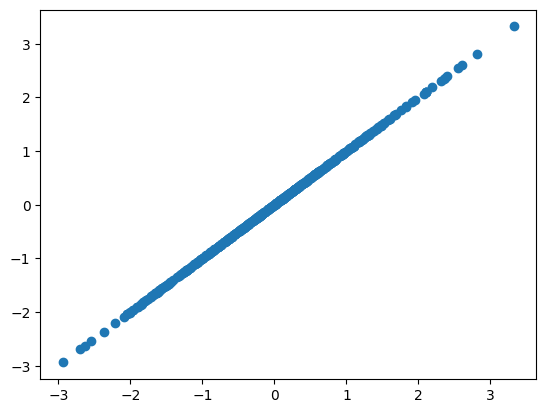

In [ ]:
plt.scatter(phenotype(P.dosages, T.effects, 1),phenotype(P.dosages, T.effects, 1))

tensor([-1.7130e+00, -1.4842e+00,  1.8420e+00,  2.2808e+00, -2.9334e+00,
        -3.5995e-01, -6.9963e-01,  3.1297e-01, -2.9214e-01, -6.1337e-01,
         5.8772e-02, -1.3480e+00, -3.2530e+00, -1.1311e-01, -8.2540e-01,
        -5.3957e-01,  4.3755e-02, -1.9632e+00, -5.0812e-01, -1.5102e+00,
        -2.0201e+00,  5.8795e-01,  1.1202e+00, -2.3467e+00, -2.9911e-01,
        -5.8674e-01, -8.8658e-01, -8.2372e-01, -1.6953e-01,  3.3492e+00,
        -2.1011e+00, -2.6834e+00,  8.8309e-01,  2.0913e+00,  8.7350e-01,
         6.8637e-01,  1.9637e+00, -1.0211e+00,  2.6680e+00,  8.6392e-02,
        -1.9765e+00,  8.2753e-01, -2.5539e+00, -1.3783e+00, -2.1248e+00,
         1.1615e-01,  3.2237e-02, -2.1447e+00,  1.4392e+00, -3.2850e-01,
         2.1264e+00, -1.5283e-02,  6.2327e-01, -1.5498e+00, -7.0515e-01,
        -1.1684e+00, -1.2624e+00, -9.4124e-01,  9.2699e-01, -8.3328e-01,
         7.8726e-01, -8.2987e-01, -1.5697e-01,  2.2387e-01, -1.4502e+00,
         7.5112e-01, -3.4184e-01,  1.8728e+00, -7.0